In [1]:
import numpy as np
import cvxpy as cp

from case import *


class MRunResult:

    def __init__(self, diesel, renew, sot, value):
        self.diesel = diesel
        self.renew = renew
        self.sot = sot
        self.value = value
        

def runMOPF(case, genData, T=1, init_sot=0.1, cycle=True, robust=False, verb=False, solver=None, **kwargs):
    # load data from case
    n = case.N
    Y = case.adj
    Sij = case.smax
    v_lim = case.vlim
    lines = case.getLines()

    renew = genData.renew
    avgs = genData.avgs
    stds = genData.stds
    batteries = genData.batteries
    diesel = genData.diesel
    Load_data = genData.Load_data
    renew_lim = genData.renew_lim

    #Voltage matrix
    V = [cp.Variable((n,n), hermitian=True) for _ in range(T)]

    # power transfer variables
    pij = cp.Variable((len(lines), T))
    pji = cp.Variable((len(lines), T))
    qij = cp.Variable((len(lines), T))
    qji = cp.Variable((len(lines), T))

    # total generation variable
    pi_g = cp.Variable((n, T))
    qi_g = cp.Variable((n, T))
    renew_real = cp.Variable((len(renew), T))
    renew_react = cp.Variable((len(renew), T))

    

    diesel_real = cp.Variable((len(diesel), T))
    diesel_react = cp.Variable((len(diesel), T))
    sot = cp.Variable((n, T))
    pow_out = cp.Variable((n, T))
    pow_in = cp.Variable((n, T))

    max_out = 2
    max_in = 3
    max_charge = 100
    eta_in = 0.95
    eta_out = 0.95

    # Define constraints
    constraints=[]

    constraints += [pow_out >= 0, pow_in >= 0, sot >= 0]
    constraints += [pow_out <= max_out, pow_in <= max_in, sot <= max_charge]

    #Constraints on active and reactive generation (min-max)
    constraints += [diesel_real >= 0, diesel_real <= 50]
    constraints += [diesel_react >= -50, diesel_react <= 50]
    constraints += [renew_react >= -50, renew_react <= 50]
    for t in range(T):
        for i in range(renew_lim.shape[0]):
            constraints += [renew_real[i, t] <= renew_lim[i, t]]
    constraints += [renew_real >= 0]


    # Calculate the sum of all inbound power flows to each bus
    for t in range(T):

        if robust:
            max_gen = np.sum(avgs[:,t])-np.linalg.norm(stds[:,t])
            if max_gen > 0:
                constraints += [cp.sum(renew_real[:,t])<=max_gen]
            else:
                constraints += [cp,sum(renew_real[:,t])<=0]
        if cycle:
            constraints += [sot[:,-1] == init_sot]

        for i in range(n) :  
            psum = 0
            qsum = 0
            for line in range(len(lines)):
                start, end = lines[line]
                if start == i:
                    psum += pij[line, t]
                    qsum += qij[line, t]
                elif end == i:
                    psum += pji[line, t]
                    qsum += qji[line, t]

            # Sum pij = pi
            if t>0 and i in batteries:
                constraints += [sot[i, t] == sot[i, t-1] + (pow_in[i, t]*eta_in-pow_out[i, t]/eta_out)]
            else:
                constraints += [sot[i, t] == init_sot]
                constraints += [pow_in[i, t]==0, pow_out[i, t] == 0]
            gensum = 0
            rgensum = 0
            if i in batteries:
                gensum += -pow_in[i, t]+pow_out[i, t]
            if i in renew:
                gensum += renew_real[renew.index(i), t]
                rgensum += renew_react[renew.index(i), t]
            if i in diesel:
                gensum += diesel_real[diesel.index(i), t]
                rgensum += diesel_react[diesel.index(i), t]
            constraints += [psum == gensum-Load_data[i,0, t]]
            # Sum qij = qi 
            constraints += [qsum == rgensum-Load_data[i,1, t]]

            

            # Voltage limits
            constraints+=[cp.real(V[t][i,i])>= 0.95**2, cp.real(V[t][i,i]) <= 1.05**2]
            constraints += [cp.imag(V[t][i,i]) == 0]

        # Power flow equations (sparse representation)
        for line in range(len(lines)):
            i, j = lines[line]
                
            #Powerflow
            constraints+=[pij[line, t] + 1j*qij[line, t]==(V[t][i,i]-V[t][i,j])*np.conjugate(Y[i,j])] 
            constraints+=[pji[line, t] + 1j*qji[line, t]==(V[t][j,j]-V[t][j,i])*np.conjugate(Y[j,i])] 
            
            if not Sij[i,j] == 0:
            #Apparent power capacity S_bar
                constraints+=[cp.square(pij[line, t])+cp.square(qij[line, t])<=cp.square(Sij[i,j])]
                constraints+=[cp.square(pji[line, t])+cp.square(qji[line, t])<=cp.square(Sij[j,i])]
                
        for line in range(len(lines)):
            i, j = lines[line]
            constraints+=[cp.norm(cp.hstack([2*V[t][i,j],(V[t][i,i]-V[t][j,j])])) <= cp.real(V[t][i,i]+V[t][j,j])]
            constraints+=[cp.norm(cp.hstack([2*V[t][j,i],(V[t][j,j]-V[t][i,i])])) <= cp.real(V[t][j,j]+V[t][i,i])]

    # Define costs
    Costs = cp.sum(diesel_real)
    
    prob = cp.Problem(cp.Minimize(Costs), constraints)
    prob.solve(verbose=verb)
    try:
        ans = MRunResult(diesel_real.value, renew_real.value, sot.value, prob.value)
    except TypeError:
        return None
    return ans

(CVXPY) May 01 07:06:52 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxopt/base.cpython-311-darwin.so, 0x0002): Library not loaded: '@rpath/liblapack.3.dylib'\n  Referenced from: '/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxopt/base.cpython-311-darwin.so'\n  Reason: tried: '/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/Users/john_schafer/anaconda3/envs/info251/bin/../lib/liblapack.3.dylib' (no such file), '/Users/john_schafer/anaconda3/envs/info251/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")
(CVXPY) May 01 07:06:52 PM: Encountered unexpected exception

In [2]:
case39 = loadCase("cases/case39.json")

In [3]:
np.sum(case39.loadData[:,0])

62.542300000000004

In [4]:
np.sum(case39.genData[:,0] == 0)

29

In [5]:
diesel = [29]
batteries = [29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
renew = [30, 31, 32, 33, 34, 35, 36, 37, 38]

class gens:

    def __init__(self, diesel, batteries, renew, avgs, stds, Load_data, renew_lim):
        self.renew = renew
        self.diesel = diesel
        self.batteries = batteries
        self.avgs = avgs
        self.stds = stds
        self.Load_data = Load_data
        self.renew_lim = renew_lim


In [6]:
import os
import matplotlib.pyplot as plt
pv_directory   = 'PV Generation Data'
load_directory = 'Building Load Data'
wind_directory = 'Wind Generation Data'

# ALREADY GENERATED, takes 5 minutes to generate again so keep commented out
#dp.generate_json_from_pv_data(pv_directory) 
#dp.generate_json_from_bldg_data(load_directory) 
#dp.generate_json_from_wind_data(wind_directory) 

with open(os.path.join(pv_directory, 'pv_data.json'), 'r') as json_file:
    pv_dict = json.load(json_file)

for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
    solar_data = np.array(pv_dict[key])
    break

# for key, value in pv_dict.items():
    # print(key, value['0'])
    # break

with open(os.path.join(load_directory, 'real_data.json'), 'r') as json_file:
    real_load_dict = json.load(json_file)

with open(os.path.join(load_directory, 'reactive_data.json'), 'r') as json_file:
    reactive_load_dict = json.load(json_file)

with open(os.path.join(wind_directory, 'wind_data.json'), 'r') as json_file:
    wind_dict = json.load(json_file)

real_load_dict['GeiselLibrary0']['0']
def toNDct(dict):
    ans = np.zeros([len(dict.keys()), 427, 96])
    for b, bld in enumerate(dict):
        for d, day in enumerate(dict[bld]):
            ans[b, d, :] = dict[bld][day]
    return ans

real_load = toNDct(real_load_dict)
react_load = toNDct(reactive_load_dict)
wind = toNDct(wind_dict)
solar = toNDct(pv_dict)


In [7]:
print(wind.shape)
print(solar.shape)

(22, 427, 96)
(67, 427, 96)


In [8]:
Load_data = np.zeros((39, 2, 24))

day_index = -4 # Feb 29, 2020 is last day (-1), so use -4 for Feb. 26 and -8 for Feb 22
Load_data[:27,:] = np.stack((real_load[:,day_index,0::4], react_load[:,day_index,0::4]), axis=1)


#Factor of 2.123 produces ~100% renewable penetration (Energy of renewables= energy of demand)
#Limits for Feb 26
renew_lim = (wind[:9,day_index,0::4]+solar[:9,day_index,0::4])*2.123


avgs = np.mean(wind[:8,:,0::4]+solar[:8,:,0::4], axis=1)*2.123
stds = np.std(wind[:8,:,0::4]+solar[:8,:,0::4], axis=1)*2.123

genDat = gens(diesel, batteries, renew, avgs, stds, Load_data, renew_lim)



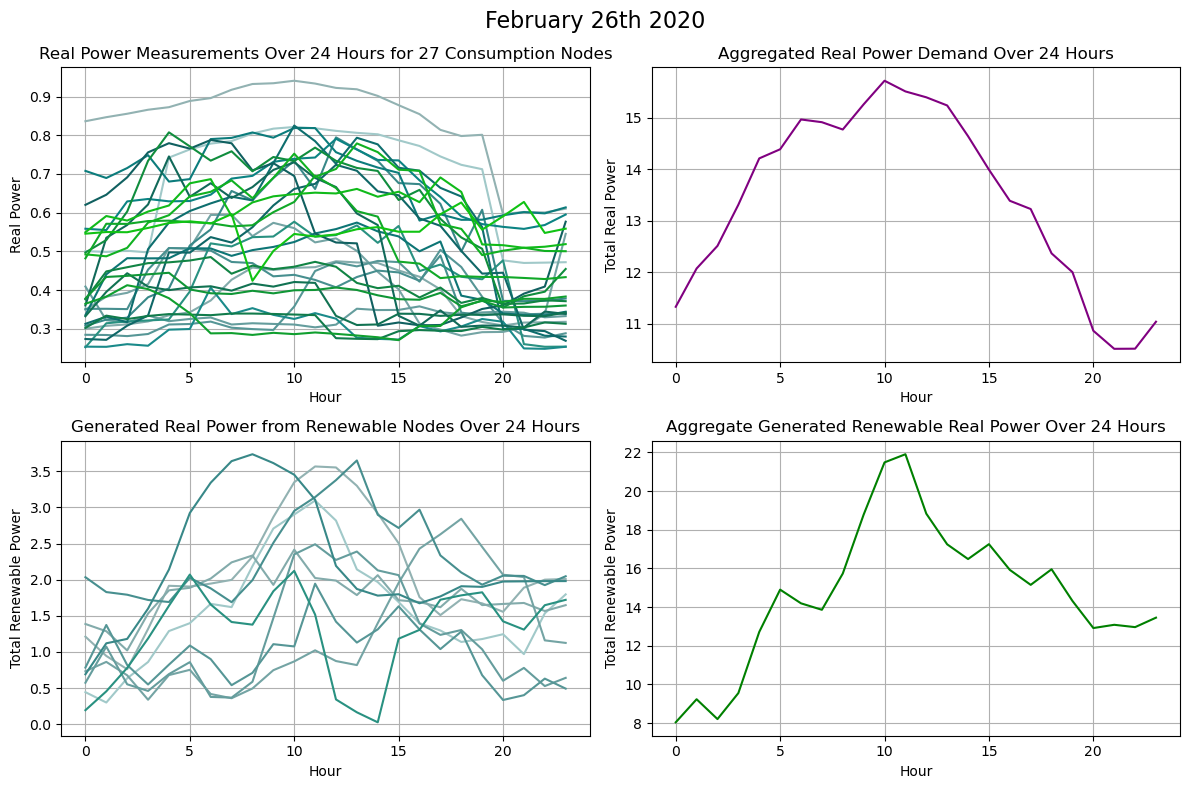

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Load_data and renew_lim are already loaded with your data
# Setup figure size and color palette
plt.figure(figsize=(12, 8))  

plt.suptitle("February 26th 2020", fontsize=16)


colors = ['#a1c9c9', '#92b2b2', '#83abab', '#74a4a4', '#659d9d', '#569696', '#478f8f', 
          '#388888', '#299181', '#1a8a8a', '#0b8383', '#0c7c7c', '#0d7575', '#0e6e6e', 
          '#0f6767', '#106060', '#116959', '#117252', '#117b4b', '#118444', '#108d3d', 
          '#109636', '#109f2f', '#10a828', '#10b121', '#10ba1a', '#10c313']

# Subplot 1: Individual node real power measurements
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot
for i in range(27):
    plt.plot(Load_data[i, 0, :], label=f'Node {i+1}', color=colors[i % len(colors)])
plt.title('Real Power Measurements Over 24 Hours for 27 Consumption Nodes')
plt.xlabel('Hour')
plt.ylabel('Real Power')
plt.grid(True)
# Optional: enabling this line will show many labels, which may clutter the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small') 

# Subplot 2: Aggregated real power
plt.subplot(2, 2, 2)
aggregated_real_power = Load_data[:, 0, :].sum(axis=0)
plt.plot(aggregated_real_power, linestyle='-', color='purple')
plt.title('Aggregated Real Power Demand Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Total Real Power')
plt.grid(True)

# Subplot 3: Renewable real power for selected nodes
plt.subplot(2, 2, 3)
for i in range(9):  # Adjust this range as necessary for your dataset
    plt.plot(renew_lim[i, :], label=f'Node {i+30}', color=colors[i % len(colors)])
plt.title('Generated Real Power from Renewable Nodes Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Total Renewable Power')
plt.grid(True)
# Optional: enabling this line will show many labels, which may clutter the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small') 

# Subplot 4: Aggregated renewable generation
plt.subplot(2, 2, 4)
aggregated_ren_power = renew_lim.sum(axis=0)
plt.plot(aggregated_ren_power, linestyle='-', color='green')
plt.title('Aggregate Generated Renewable Real Power Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Total Renewable Power')
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Total Renewable Energy Generated (Units): 341.51219697502296
Total Energy Consumed (Units): 311.03256368860303
Renewable Penetration: 109.79949910226611 %


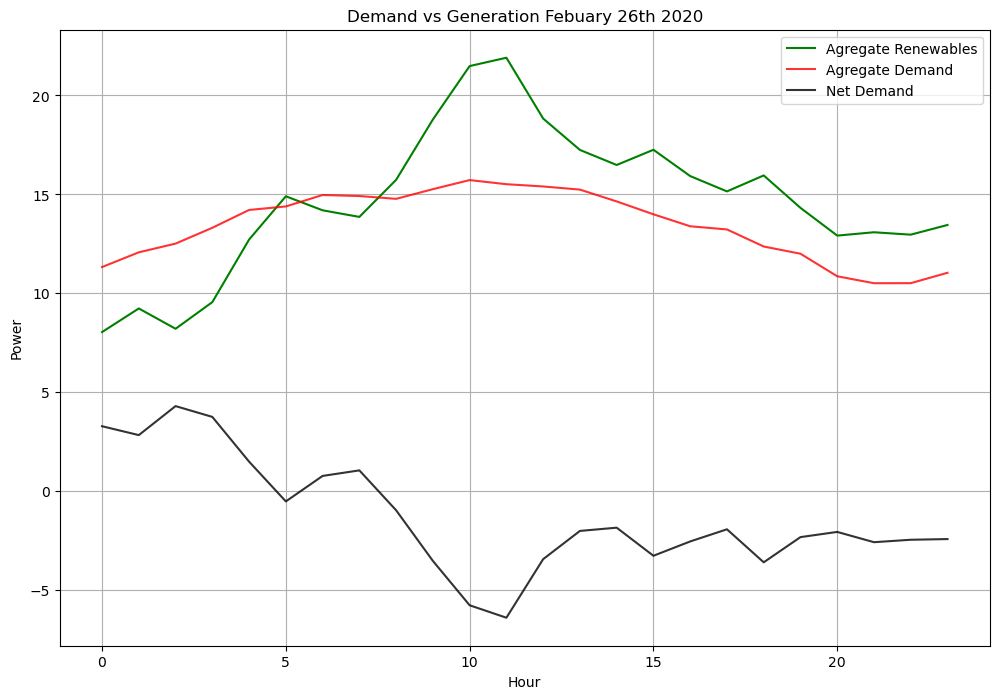

In [10]:
#Plots for scaling
plt.figure(figsize=(12,8))
plt.plot(aggregated_ren_power, linestyle='-', color='green', label='Agregate Renewables')
plt.plot(aggregated_real_power, linestyle='-', color='red', alpha=.8, label='Agregate Demand')
plt.plot(aggregated_real_power-aggregated_ren_power, linestyle='-', color='black', alpha=.8, label='Net Demand')
plt.title('Demand vs Generation Febuary 26th 2020')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.grid(True)

#Calculating % of Renewable Penetration
total_renewable_energy = np.trapz(aggregated_ren_power, dx=1) 
total_real_energy = np.trapz(aggregated_real_power, dx=1)
renewable_penetration= (total_renewable_energy/ total_real_energy)*100
print(f"Total Renewable Energy Generated (Units): {total_renewable_energy}")
print(f"Total Energy Consumed (Units): {total_real_energy}")
print(f"Renewable Penetration: {renewable_penetration} %")

In [11]:
#NON-ROBUST
#SoC Initial=50%
res = runMOPF(case39, genDat, T=24, init_sot=10)

/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/john_schafer/anaconda3/envs/info251/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


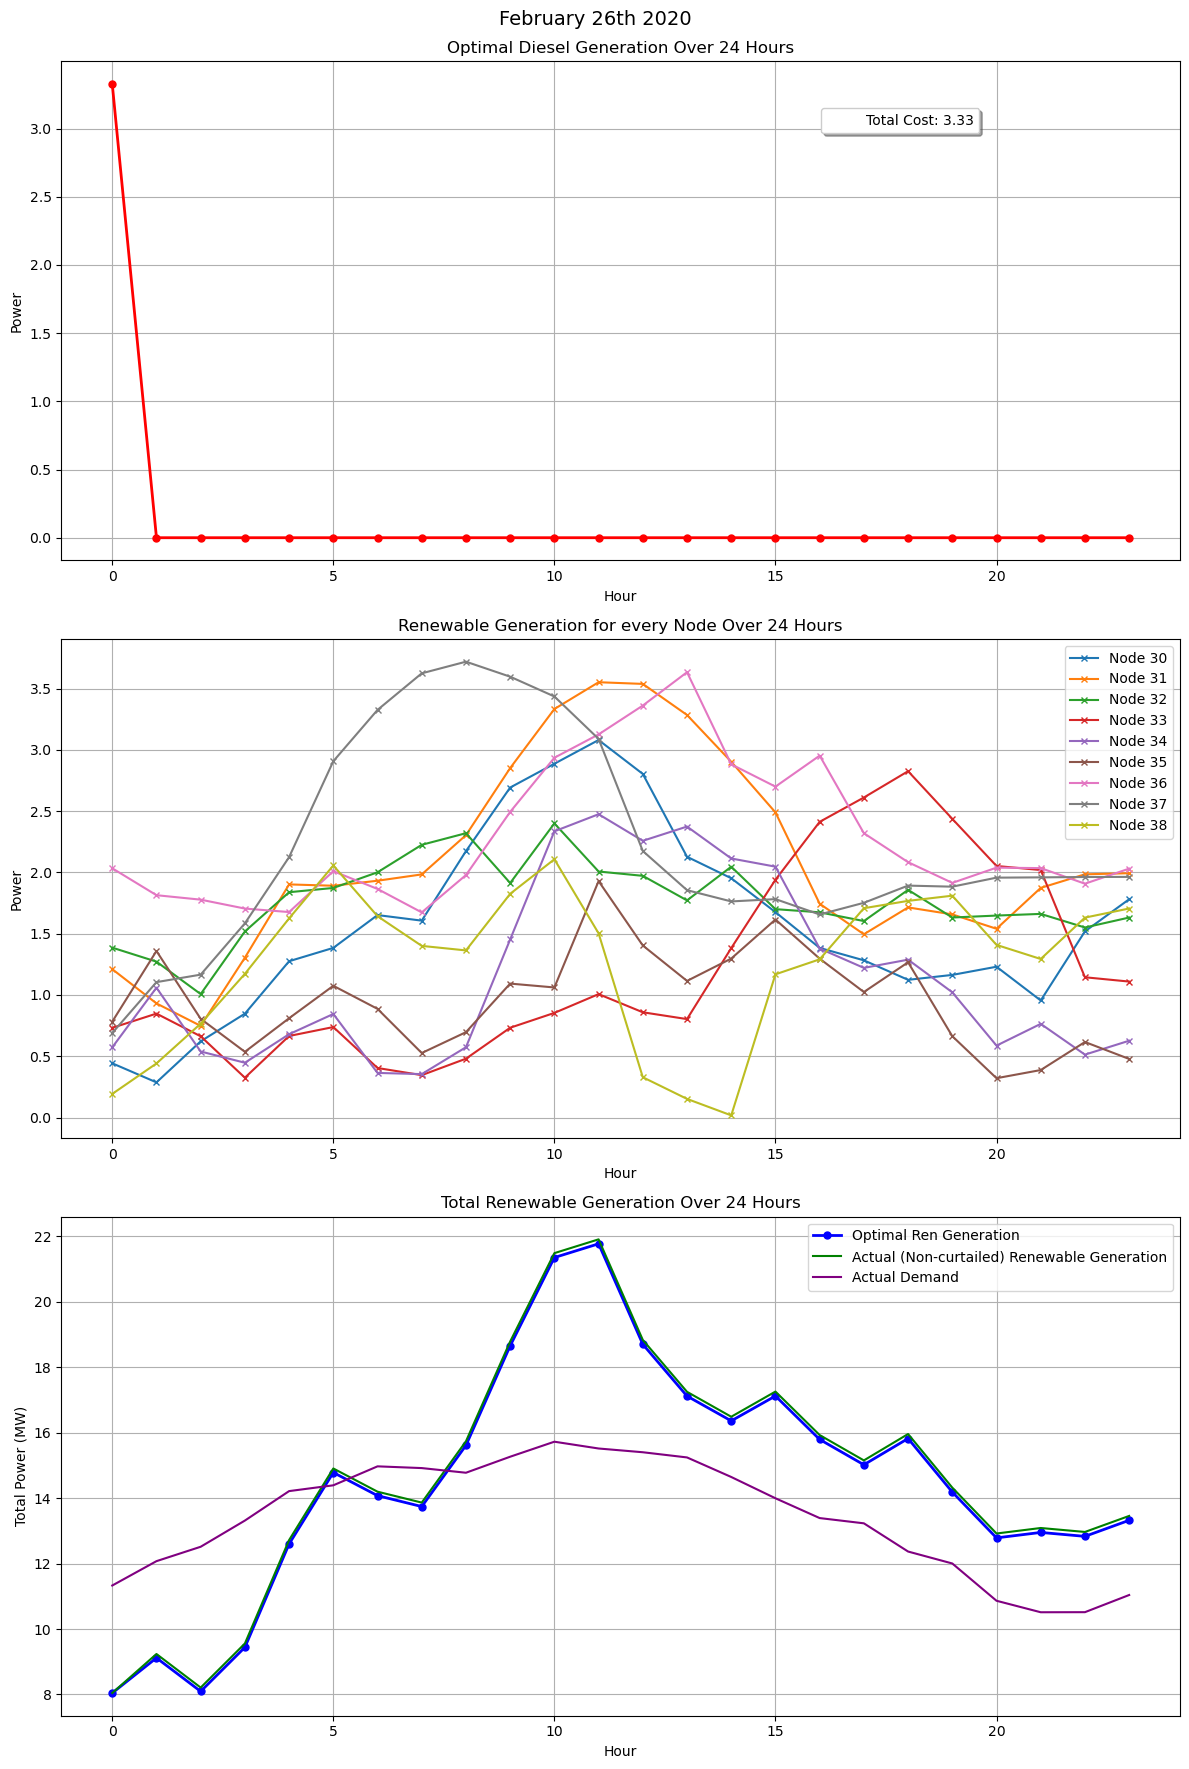

In [12]:
#NON-ROBUST
import matplotlib.patches as mpatches

diesel_power = res.diesel.flatten()
renewable_power = res.renew 
cost_nonrobust=np.round(res.value,2)

plt.figure(figsize=(12, 18))  

plt.suptitle("February 26th 2020", fontsize=14)

plt.subplot(3, 1, 1) 
plt.plot(diesel_power, color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('Optimal Diesel Generation Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Power')
cost_patch = mpatches.Patch(color='white', label=f'Total Cost: {cost_nonrobust}')
plt.legend(handles=[cost_patch], loc='upper center', bbox_to_anchor=(.75, .92),
           fancybox=True, shadow=True, ncol=1)
plt.grid(True)


plt.subplot(3, 1, 2)  
for i in range(9):  
    plt.plot(renewable_power[i, :], marker='x', linestyle='-', linewidth=1.5, markersize=4, label=f'Node {i+30}')
plt.title('Renewable Generation for every Node Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3) 
total_renewable_power = np.sum(renewable_power, axis=0)
plt.plot(total_renewable_power, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Optimal Ren Generation')
plt.plot(aggregated_ren_power, linestyle='-', color='green', label='Actual (Non-curtailed) Renewable Generation')
plt.plot(aggregated_real_power, linestyle='-', color='purple', label='Actual Demand')
plt.title('Total Renewable Generation Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Total Power (MW)')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


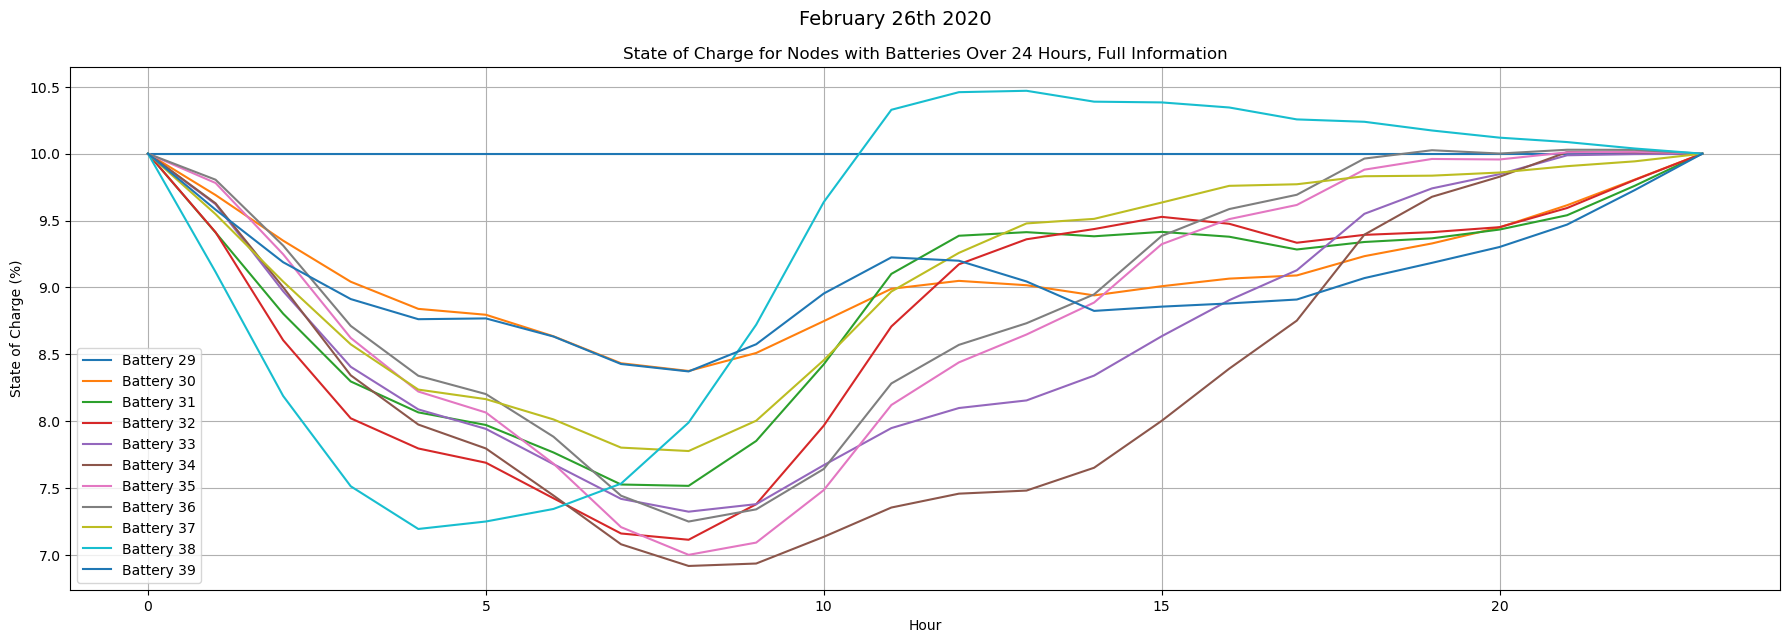

In [18]:

sot = res.sot

# Nodes with batteries are from index 28 to 37 (29 to 38 in 1-based index)
battery_indices = list(range(28, 39))  


plt.figure(figsize=(18, 12))
plt.suptitle("February 26th 2020", fontsize=14)

plt.subplot(2, 1, 1)
for i in battery_indices:
    plt.plot(sot[i, :], label=f'Battery {i+1}')
plt.title('State of Charge for Nodes with Batteries Over 24 Hours, Full Information')
plt.xlabel('Hour')
plt.ylabel('State of Charge (%)')
plt.legend()
plt.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


In [14]:
#ROBUST
res_robust = runMOPF(case39, genDat, T=24, init_sot=10, robust=True)
print('Robust Cost', np.round(res_robust.value,2))

Robust Cost 148.8


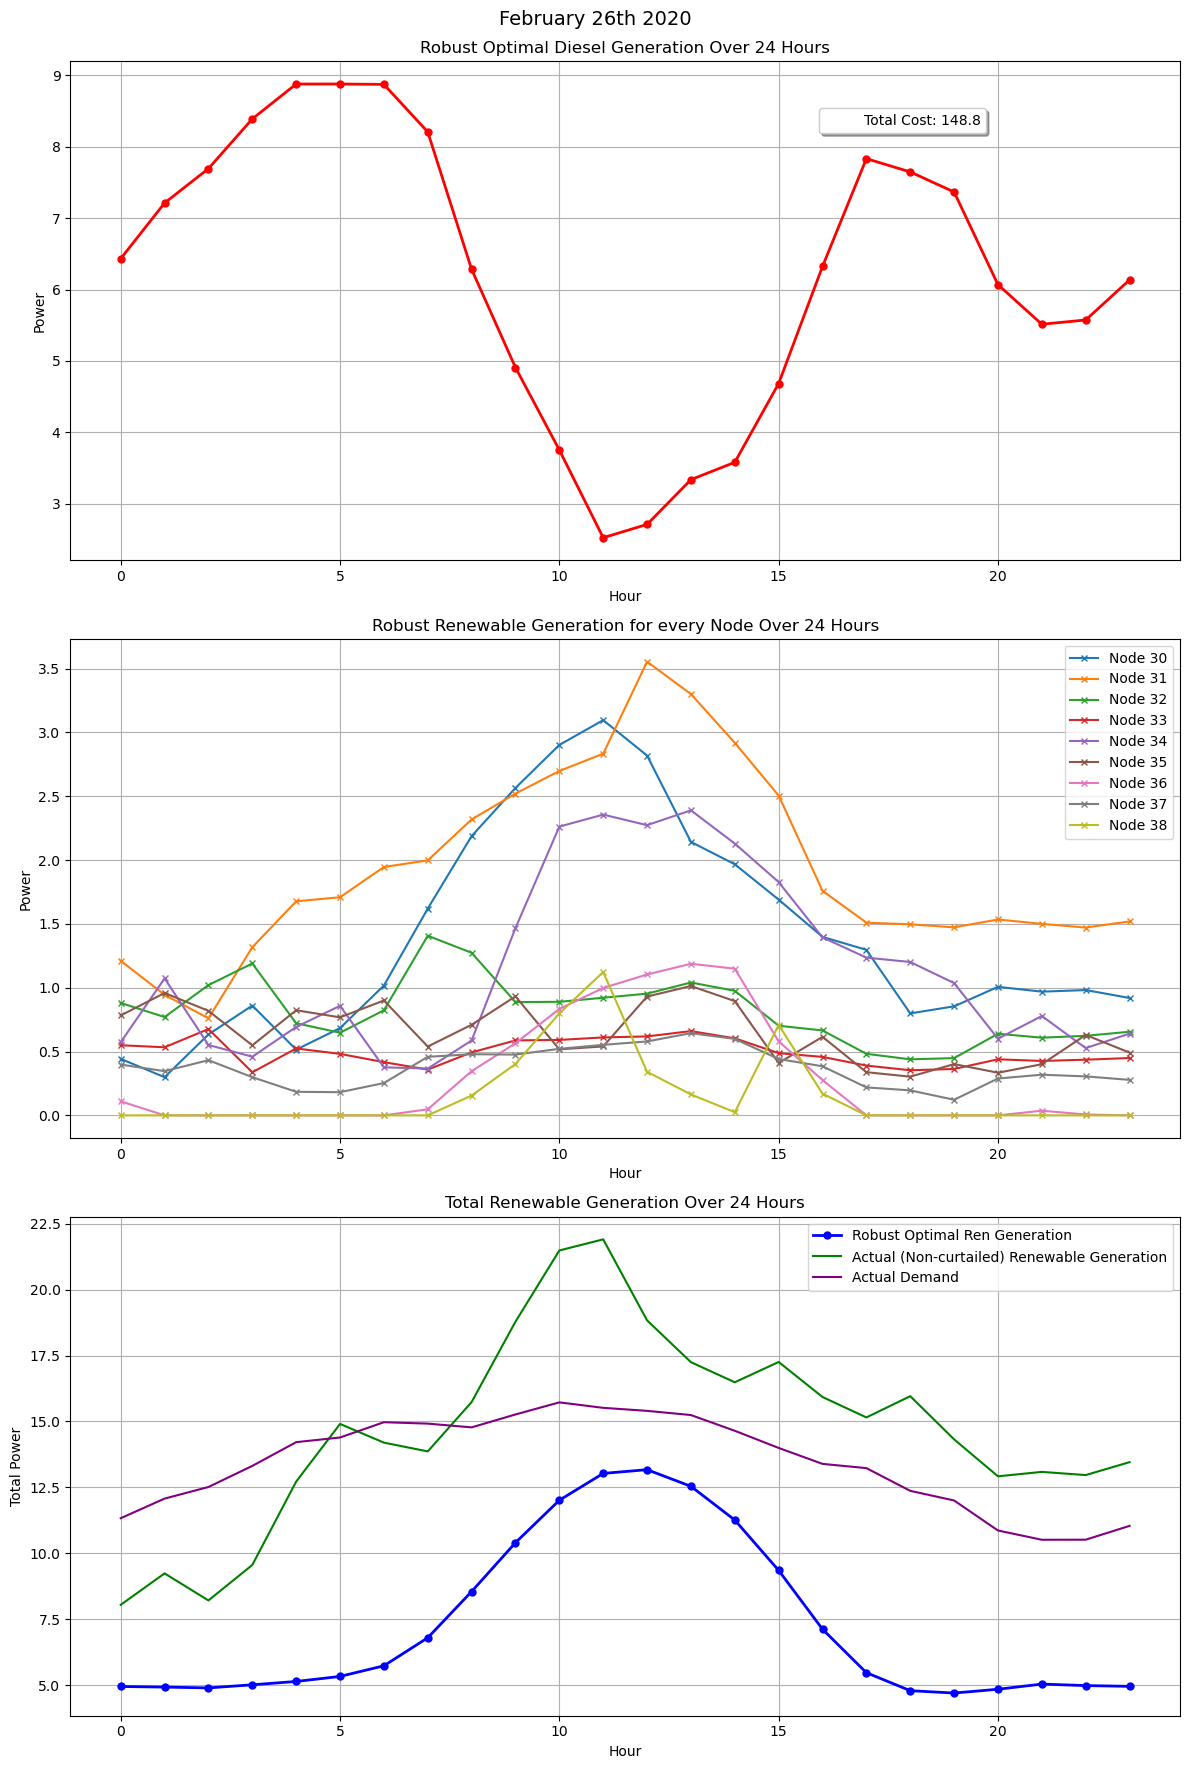

In [15]:
#ROBUST
import matplotlib.patches as mpatches

diesel_power_robust = res_robust.diesel.flatten()
renewable_power_robust = res_robust.renew 
cost_robust=np.round(res_robust.value,2)

plt.figure(figsize=(12, 18))

plt.suptitle("February 26th 2020", fontsize=14)

plt.subplot(3, 1, 1) 
plt.plot(diesel_power_robust, color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('Robust Optimal Diesel Generation Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Power')
cost_patch_robust = mpatches.Patch(color='white', label=f'Total Cost: {cost_robust}')
plt.legend(handles=[cost_patch_robust], loc='upper center', bbox_to_anchor=(.75, .92),
           fancybox=True, shadow=True, ncol=1)
plt.grid(True)


plt.subplot(3, 1, 2)  
for i in range(9):  
    plt.plot(renewable_power_robust[i, :], marker='x', linestyle='-', linewidth=1.5, markersize=4, label=f'Node {i+30}')
plt.title('Robust Renewable Generation for every Node Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3) 
total_renewable_power_robust = np.sum(renewable_power_robust, axis=0)
plt.plot(total_renewable_power_robust, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Robust Optimal Ren Generation')
plt.plot(aggregated_ren_power, linestyle='-', color='green', label='Actual (Non-curtailed) Renewable Generation')
plt.plot(aggregated_real_power, linestyle='-', color='purple', label='Actual Demand')
plt.title('Total Renewable Generation Over 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Total Power')
plt.legend()
plt.grid(True)

# Adjusting layout and showing the plot
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


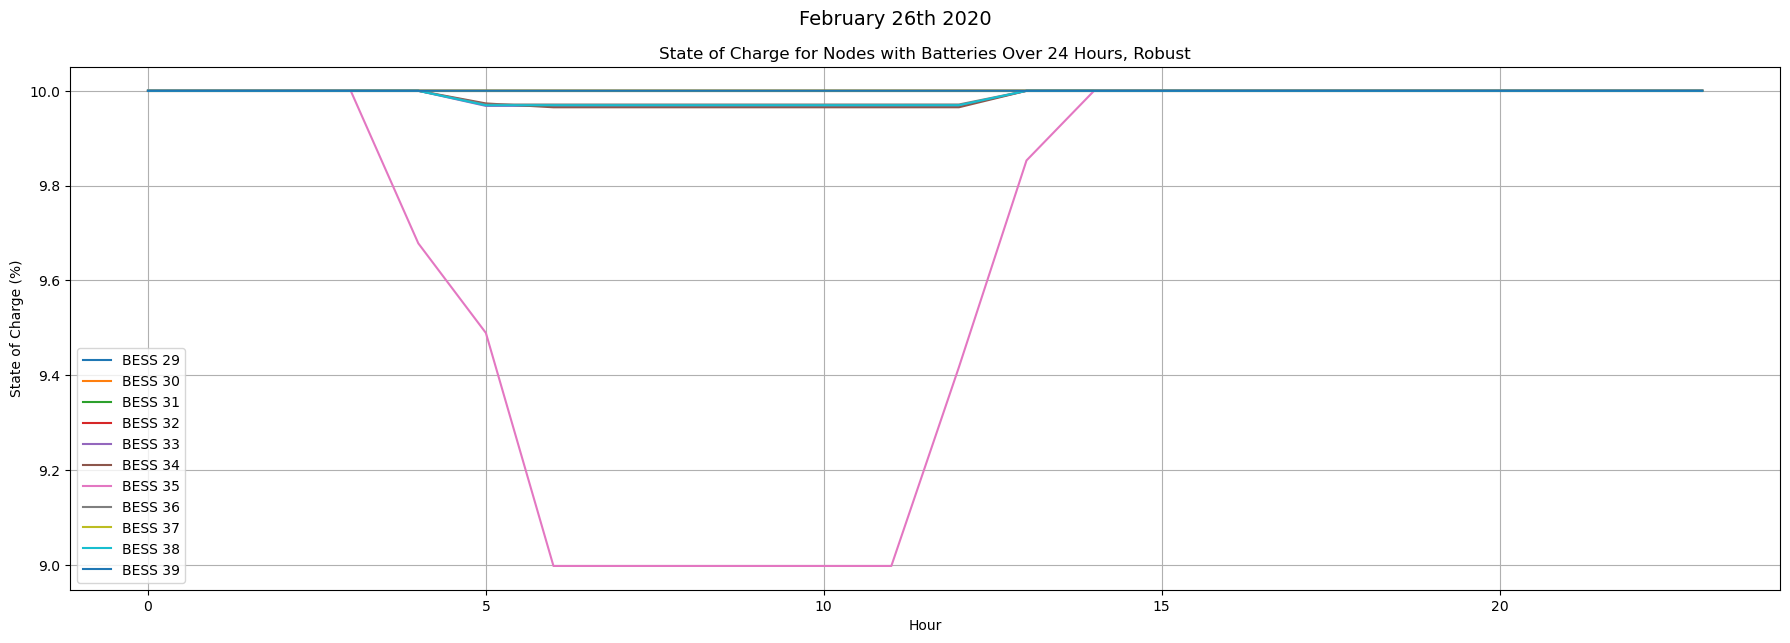

In [17]:

SoC_robust = res_robust.sot

# Nodes with batteries are from index 28 to 37 (29 to 38 in 1-based index)
battery_indices = list(range(28, 39))  # Adjust Python 0-based index

# Setting up the plot
plt.figure(figsize=(18, 12))
plt.suptitle("February 26th 2020", fontsize=14)

# Plotting line graphs for each battery-equipped node
plt.subplot(2, 1, 1)
for i in battery_indices:
    plt.plot(SoC_robust[i, :], label=f'BESS {i+1}')
plt.title('State of Charge for Nodes with Batteries Over 24 Hours, Robust')
plt.xlabel('Hour')
plt.ylabel('State of Charge (%)')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()
